# Gadget Web Scraping

#### We will be scraping TechNave, a website with a list of all, if not most, devices in the malaysian market.

#### This makes it a suitable website to scrape using Beautifulsoup before doing some data cleaning and exploratory data analysis and visualisation.

In [ ]:
pip install cloudscraper beautifulsoup4

In [106]:
import cloudscraper #avoid CloudFare restriction
from bs4 import BeautifulSoup
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
scraper = cloudscraper.create_scraper() 

In [ ]:
url = 'https://technave.com/gadgets/Mobile-Phone-Price-Malaysia-10.html'
html = scraper.get(url).text
soup = BeautifulSoup(html, "html.parser")

In [15]:
base_url = "https://technave.com/"
models = []
model_divs = soup.find_all('div', class_='model_name')

In [16]:
for div in model_divs:
    a_tag = div.find('a')
    if a_tag:
        name = a_tag.text.strip()
        link = a_tag.get('href')
        full_link = link if link.startswith('http') else base_url + link
        models.append((name, full_link))

In [ ]:
for i, (name, link) in enumerate(models, 1):
    print(f"{i}. {name} → {link}")

In [31]:
models_expanded = []

for name, link in models:
    model_page = scraper.get(link)
    model_soup = BeautifulSoup(model_page.text, 'html.parser')

    # Add main model
    models_expanded.append((name, link))

    # Add variants
    variant_divs = model_soup.find_all('div', class_='variant_div')[1:]  # skip main
    for i, variant_div in enumerate(variant_divs, 1):
        variant_link = variant_div.find('a')['href']
        full_variant_link = "https://technave.com/" + variant_link
        variant_name = f"{name} (Variant {i})"
        models_expanded.append((variant_name, full_variant_link))

In [ ]:
for i, (name, link) in enumerate(models_expanded, 1):
    print(f"{i}. {name} → {link}")

In [33]:
def extract_specs(name, url):
    page = scraper.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')

    specs_table = soup.find('table', id='gadget-specs')
    tds = specs_table.find_all('td')

    # Extract each field
    release_date = tds[0].text.strip()
    processor = tds[1].text.strip()
    chipset = tds[2].text.strip()
    gpu = tds[3].text.strip()
    ram_storage = tds[4].text.strip()
    battery = tds[7].text.strip()  # Index 7 = 8th td

    price_span = soup.find('span', id='pricefrom')
    price = price_span.text.strip() if price_span else "N/A"

    return {
        "model": name,
        "release_date": release_date,
        "price": price,
        "ram_storage": ram_storage,
        "battery": battery,
        "processor": processor,
        "gpu": gpu,
        "chipset": chipset,
        "url": url
    }

In [34]:
all_specs = []

for name, url in models_expanded:
    specs = extract_specs(name, url)
    all_specs.append(specs)

In [ ]:
all_specs

In [ ]:
df = pd.DataFrame(all_specs)

In [85]:
# Remove different formats from release_date
df['release_date'] = df['release_date'].str.replace(r'^Release\s+', '', regex=True)
df['release_date'] = df['release_date'].str.replace(r'^Available\.?\s*Released\s+', '', regex=True)
df['release_date'] = df['release_date'].str.replace(r'^Exp\.?\s*release\s+', '', regex=True)
df['release_date'] = df['release_date'].str.replace(r'^Coming soon\.?\s*Exp\.?\s*release\s+', '', regex=True)
df['release_date'] = df['release_date'].apply(lambda x: x.split(',')[0] if 'Q' in x else x)

df['release_date'] = pd.to_datetime(df['release_date'], format='mixed')

In [86]:
def extract_ram_storage(text):
    text = str(text).upper()  # Normalize case (e.g., "Tb" → "TB")
    
    # Find all memory sizes in GB or TB
    gb_matches = re.findall(r'(\d+)\s*GB', text)
    tb_matches = re.findall(r'(\d+)\s*TB', text)

    # Convert to integers
    sizes = [int(gb) for gb in gb_matches]
    sizes += [int(tb) * 1024 for tb in tb_matches]  # Convert TB to GB

    sizes = sorted(sizes)
    if len(sizes) == 0:
        return pd.Series([None, None])
    elif len(sizes) == 1:
        return pd.Series([sizes[0], None])
    else:
        return pd.Series([sizes[0], sizes[1]])

df[['ram', 'storage']] = df['ram_storage'].apply(extract_ram_storage)

In [89]:
df['battery_capacity'] = df['battery'].str.extract(r'(\d+)\s*mAh', expand=False).astype(float)

In [90]:
df

,model,release_date,price,ram_storage,battery,processor,gpu,chipset,url,ram,storage,battery_capacity
0,nubia RedMagic 10S Pro,2025-06-01,3999,"12GB RAM, 256GB ROM",Si/C Li-Ion 7050 mAh battery80W wired,Octa-core (2x4.47 GHz Oryon V2 Phoenix L + 6x3...,Adreno 830 (1200 MHz),Qualcomm SM8750-AB Snapdragon 8 Elite (3 nm),https://technave.com/gadget/nubia-RedMagic-10S...,12.0,256.0,7050.0
1,nubia RedMagic 10S Pro (Variant 1),2025-06-01,4899,"16GB RAM, 512GB ROM",Si/C Li-Ion 7050 mAh battery80W wired,Octa-core (2x4.47 GHz Oryon V2 Phoenix L + 6x3...,Adreno 830 (1200 MHz),Qualcomm SM8750-AC Snapdragon 8 Elite (3 nm),https://technave.com/gadget/nubia-RedMagic-10S...,16.0,512.0,7050.0
2,nubia RedMagic 10S Pro (Variant 2),2025-06-01,5999,"24GB RAM, 1TB ROM",Si/C Li-Ion 7050 mAh battery80W wired,Octa-core (2x4.47 GHz Oryon V2 Phoenix L + 6x3...,Adreno 830 (1200 MHz),Qualcomm SM8750-AC Snapdragon 8 Elite (3 nm),https://technave.com/gadget/nubia-RedMagic-10S...,24.0,1024.0,7050.0
3,Oppo A5i,2025-06-01,399,"4GB RAM, 128GB ROM","5100mAh/19.95Wh, 45W SUPERVOOC TM Flash Charge...",Octa-core (4x2.1 GHz Cortex-A73 & 4x1.8 GHz Co...,Adreno 610,Qualcomm SM-6115 Snapdragon 6s 4G Gen1 (11 nm),https://technave.com/gadget/Oppo-A5i-Price-in-...,4.0,128.0,5100.0
4,Realme P3 Ultra,2025-06-01,1699,"12GB RAM, 256GB ROM","Si/C Li-Ion 6000 mAh battery80W wired, PD, 100...",Octa-core (1x3.35 GHz Cortex-A715 & 3x3.20 GHz...,Mali G615-MC6,Mediatek Dimensity 8350 Ultra (4 nm),https://technave.com/gadget/Realme-P3-Ultra-Pr...,12.0,256.0,6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
598,vivo Y55 5G,2022-10-01,769,"128GB, 6GB RAM","Li-Po 5000 mAh, non-removable batteryFast char...",Octa-core (2x2.2 GHz Cortex-A76 & 6x2.0 GHz Co...,Mali-G57 MC2,MediaTek MT6833 Dimensity 700 (7 nm),https://technave.com/gadget/vivo-Y55-5G-Price-...,6.0,128.0,5000.0
599,Nokia X30,2022-10-01,1845,"256GB, 8GB RAM","Li-Po 4200 mAh, non-removable batteryFast char...",Octa-core (2x2.2 GHz Kryo 660 Gold & 6x1.7 GHz...,Adreno 619,Qualcomm SM6375 Snapdragon 695 5G (6 nm),https://technave.com/gadget/Nokia-X30-Price-in...,8.0,256.0,4200.0
600,Samsung Galaxy A04s,2022-10-01,579,"4GB RAM, 64GB ROM","Li-Po 5000 mAh, non-removable battery",Octa-core (4x2.0 GHz Cortex-A55 & 4x2.0 GHz Co...,Mali-G52,Exynos 850 (8nm),https://technave.com/gadget/Samsung-Galaxy-A04...,4.0,64.0,5000.0
601,Oppo A17k,2022-10-01,389,"64GB 3GB RAM, eMMC 5.1","Li-Po 5000 mAh, non-removable battery",Octa-core (4x2.3 GHz Cortex-A53 & 4x1.8 GHz Co...,PowerVR GE8320,MediaTek MT6765 Helio G35 (12 nm),https://technave.com/gadget/Oppo-A17k-Price-in...,3.0,64.0,5000.0


In [96]:
df[df[['ram', 'storage']].isnull().any(axis=1)]

,model,release_date,price,ram_storage,battery,processor,gpu,chipset,url,ram,storage,battery_capacity
40,nubia Neo 3,2025-04-01,999,8GB RAM,6000 mAh or 5000 mAh battery33W wired\r\nBypas...,Octa-core (2x2.2 GHz Cortex-A78 & 6x2.0 GHz Co...,Mali-G57 MP2,Unisoc T8300 (6 nm),https://technave.com/gadget/nubia-Neo-3-Price-...,8.0,NaN,6000.0
78,Apple iPhone 16e,2025-02-01,2879,128GB,"Li-Ion batteryWired, 50% in 30 min\r\n7.5W wir...",Hexa-core (2x4.04 GHz + 4x2.20 GHz),Apple GPU (4-core graphics),Apple A18 (3 nm),https://technave.com/gadget/Apple-iPhone-16e-P...,128.0,NaN,NaN
79,Apple iPhone 16e (Variant 1),2025-02-01,3499,256GB,"Li-Ion batteryWired, 50% in 30 min\r\n7.5W wir...",Hexa-core (2x4.04 GHz + 4x2.20 GHz),Apple GPU (4-core graphics),Apple A18 (3 nm),https://technave.com/gadget/Apple-iPhone-16e-2...,256.0,NaN,NaN
80,Apple iPhone 16e (Variant 2),2025-02-01,4499,512GB,"Li-Ion batteryWired, 50% in 30 min\r\n7.5W wir...",Hexa-core (2x4.04 GHz + 4x2.20 GHz),Apple GPU (4-core graphics),Apple A18 (3 nm),https://technave.com/gadget/Apple-iPhone-16e-5...,512.0,NaN,NaN
81,nubia V70 Max,2025-02-01,398,(6+6) GB + 128GB,6000 mAh battery22.5W wired,Octa-core (2x1.6 GHz Cortex-A75 & 6x1.6 GHz Co...,Mali-G57 MP1,Unisoc T606 (12 nm),https://technave.com/gadget/nubia-V70-Max-Pric...,128.0,NaN,6000.0
121,Huawei nova 13 Pro,2024-12-01,2119,"5000 mAh battery100W wired, 3-50% in 9 min (ad...",Aluminosilicate glass,"12GB RAM, 512GB ROM",HarmonyOS 4.2,No,https://technave.com/gadget/Huawei-nova-13-Pro...,NaN,NaN,NaN
122,Huawei nova 13,2024-12-01,1599,"5000 mAh battery100W wired, 3-50% in 10 min (a...",Aluminosilicate glass,"12GB RAM, 256GB ROM",HarmonyOS 4.2,No,https://technave.com/gadget/Huawei-nova-13-Pri...,NaN,NaN,NaN
126,realme C75,2024-12-01,659,microSDXC (dedicated slot),"6.72 inches, 109.0 cm2 (~86.3% screen-to-body ...",Octa-core 2.0 GHz,"8GB RAM, 256GB ROM",Mediatek Helio G92 Max,https://technave.com/gadget/realme-C75-Price-i...,NaN,NaN,NaN
138,HMD 105,2024-12-01,109,"1000 mAh, removable battery",115.5 x 49.5 x 14 mm,4 MB 4 MB RAM,RTOS OS,microSDHC,https://technave.com/gadget/HMD-105-Price-in-M...,NaN,NaN,NaN
184,Oppo A3 4G,2024-09-01,635,microSDXC,"6.67 inches, 107.2 cm2 (~85.0% screen-to-body ...",Qualcomm Snapdragon 6s Gen 1,"8GB RAM, 128GB ROM",Adreno 610,https://technave.com/gadget/Oppo-A3-4G-Price-i...,NaN,NaN,NaN


In [97]:
manual_overrides = {
    'nubia Neo 3': {'ram': 8, 'storage': 256},
    'Apple iPhone 16e': {'ram': 8, 'storage': 128},
    'Apple iPhone 16e (Variant 1)': {'ram': 8, 'storage': 256},
    'Apple iPhone 16e (Variant 2)': {'ram': 8, 'storage': 512},
    'nubia V70 Max': {'ram': 6, 'storage': 128},
    'Huawei nova 13 Pro': {'ram': 12, 'storage': 512},
    'Huawei nova 13': {'ram': 12, 'storage': 256},
    'realme C75': {'ram': 8, 'storage': 256},
    'HMD 105': {'ram': 0.004, 'storage': 0.004},
    'Oppo A3 4G': {'ram': 8, 'storage': 128},
    'Huawei Mate XT Ultimate': {'ram': 16, 'storage': 1024},
    'iPhone 16 Pro Max': {'ram': 8, 'storage': 256},
    'iPhone 16 Pro Max (Variant 1)': {'ram': 8, 'storage': 512},
    'iPhone 16 Pro Max (Variant 2)': {'ram': 8, 'storage': 1024},
    'iPhone 16 Pro': {'ram': 8, 'storage': 128},
    'iPhone 16 Pro (Variant 1)': {'ram': 8, 'storage': 256},
    'iPhone 16 Pro (Variant 2)': {'ram': 8, 'storage': 512},
    'iPhone 16 Pro (Variant 3)': {'ram': 8, 'storage': 1024},
    'Apple iPhone 16 Plus': {'ram': 8, 'storage': 128},
    'Apple iPhone 16 Plus (Variant 1)': {'ram': 8, 'storage': 256},
    'Apple iPhone 16 Plus (Variant 2)': {'ram': 8, 'storage': 512},
    'Apple iPhone 16': {'ram': 8, 'storage': 128},
    'Apple iPhone 16 (Variant 1)': {'ram': 8, 'storage': 256},
    'Apple iPhone 16 (Variant 2)': {'ram': 8, 'storage': 512},
    'Google Pixel 9 Pro XL': {'ram': 16, 'storage': 256},
    'Google Pixel 9 Pro XL (Variant 1)': {'ram': 16, 'storage': 512},
    'Google Pixel 9 Pro XL (Variant 2)': {'ram': 16, 'storage': 1024},
    'Google Pixel 9 Pro': {'ram': 16, 'storage': 256},
    'Google Pixel 9': {'ram': 12, 'storage': 256},
    'Huawei Pura 70 Pro': {'ram': 12, 'storage': 256},
    'Huawei Pura 70 Ultra': {'ram': 16, 'storage': 512},
    'Huawei Pura 70 Ultra (Variant 1)': {'ram': 16, 'storage': 1024},
    'Huawei Pura 70': {'ram': 12, 'storage': 256},
    'nubia Neo 2': {'ram': 8, 'storage': 256},
    'Samsung Galaxy A55': {'ram': 12, 'storage': 256},
    'ZTE Blade V50 Design': {'ram': 10, 'storage': 256},
    'realme C30s': {'ram': 4, 'storage': 64},
    'realme C30s (Variant 1)': {'ram': 4, 'storage': 64},
    'Samsung Galaxy A04': {'ram': 4, 'storage': 64},
    'Samsung Galaxy A04 (Variant 1)': {'ram': 4, 'storage': 64}
}

In [98]:
for model, values in manual_overrides.items():
    mask = df['model'] == model
    if 'ram' in values and values['ram'] is not None:
        df.loc[mask, 'ram'] = values['ram']
    if 'storage' in values and values['storage'] is not None:
        df.loc[mask, 'storage'] = values['storage']

In [99]:
df.isnull().sum()

model                0
release_date         0
price                0
ram_storage          0
battery              0
processor            0
gpu                  0
chipset              0
url                  0
ram                  0
storage              0
battery_capacity    51
dtype: int64

In [100]:
df['brand'] = df['model'].str.extract(r'^(\w+)')

In [102]:
df['brand'].value_counts()

brand
Samsung     62
vivo        47
Redmi       45
Oppo        44
Poco        40
Realme      38
nubia       37
Infinix     33
Xiaomi      25
Huawei      25
Honor       23
TECNO       22
Apple       22
iQOO        19
realme      17
HONOR       15
OnePlus     15
Asus        10
Google      10
HMD          9
Nothing      8
iPhone       7
ASUS         6
Sony         5
ZTE          4
Meizu        3
Tecno        3
OPPO         2
Moto         2
POCO         2
Motorola     2
Nokia        1
Name: count, dtype: int64

In [116]:
df['brand'] = df['brand'].replace({
    'iPhone': 'Apple',
    'ASUS': 'Asus'
})

desired_order = [
    'model', 'brand', 'ram', 'storage', 'price',
    'processor', 'gpu', 'chipset', 'battery', 'battery_capacity'
]

df = df[desired_order]
df

C:\Users\Umer\AppData\Local\Temp\ipykernel_37528\2437419429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['brand'] = df['brand'].replace({


,model,brand,ram,storage,price,processor,gpu,chipset,battery,battery_capacity
0,nubia RedMagic 10S Pro,nubia,12,256,3999,Octa-core (2x4.47 GHz Oryon V2 Phoenix L + 6x3...,Adreno 830 (1200 MHz),Qualcomm SM8750-AB Snapdragon 8 Elite (3 nm),Si/C Li-Ion 7050 mAh battery80W wired,7050.0
1,nubia RedMagic 10S Pro (Variant 1),nubia,16,512,4899,Octa-core (2x4.47 GHz Oryon V2 Phoenix L + 6x3...,Adreno 830 (1200 MHz),Qualcomm SM8750-AC Snapdragon 8 Elite (3 nm),Si/C Li-Ion 7050 mAh battery80W wired,7050.0
2,nubia RedMagic 10S Pro (Variant 2),nubia,24,1024,5999,Octa-core (2x4.47 GHz Oryon V2 Phoenix L + 6x3...,Adreno 830 (1200 MHz),Qualcomm SM8750-AC Snapdragon 8 Elite (3 nm),Si/C Li-Ion 7050 mAh battery80W wired,7050.0
3,Oppo A5i,Oppo,4,128,399,Octa-core (4x2.1 GHz Cortex-A73 & 4x1.8 GHz Co...,Adreno 610,Qualcomm SM-6115 Snapdragon 6s 4G Gen1 (11 nm),"5100mAh/19.95Wh, 45W SUPERVOOC TM Flash Charge...",5100.0
4,Realme P3 Ultra,Realme,12,256,1699,Octa-core (1x3.35 GHz Cortex-A715 & 3x3.20 GHz...,Mali G615-MC6,Mediatek Dimensity 8350 Ultra (4 nm),"Si/C Li-Ion 6000 mAh battery80W wired, PD, 100...",6000.0
...,...,...,...,...,...,...,...,...,...,...
598,vivo Y55 5G,vivo,6,128,769,Octa-core (2x2.2 GHz Cortex-A76 & 6x2.0 GHz Co...,Mali-G57 MC2,MediaTek MT6833 Dimensity 700 (7 nm),"Li-Po 5000 mAh, non-removable batteryFast char...",5000.0
599,Nokia X30,Nokia,8,256,1845,Octa-core (2x2.2 GHz Kryo 660 Gold & 6x1.7 GHz...,Adreno 619,Qualcomm SM6375 Snapdragon 695 5G (6 nm),"Li-Po 4200 mAh, non-removable batteryFast char...",4200.0
600,Samsung Galaxy A04s,Samsung,4,64,579,Octa-core (4x2.0 GHz Cortex-A55 & 4x2.0 GHz Co...,Mali-G52,Exynos 850 (8nm),"Li-Po 5000 mAh, non-removable battery",5000.0
601,Oppo A17k,Oppo,3,64,389,Octa-core (4x2.3 GHz Cortex-A53 & 4x1.8 GHz Co...,PowerVR GE8320,MediaTek MT6765 Helio G35 (12 nm),"Li-Po 5000 mAh, non-removable battery",5000.0


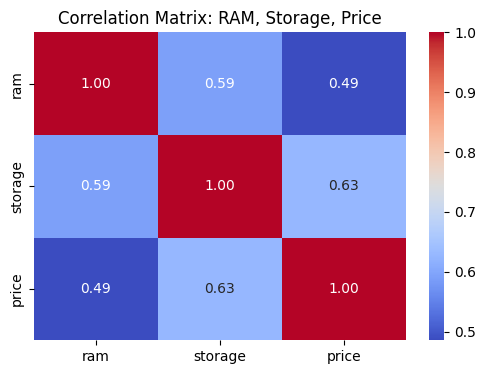

In [117]:
corr = df[['ram', 'storage', 'price']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: RAM, Storage, Price')
plt.show()

In [118]:
df['ram'] = df['ram'].astype(int)
df['storage'] = df['storage'].astype(int)
df['price'] = df['price'].astype(int)
df.dtypes

model                object
brand                object
ram                   int64
storage               int64
price                 int64
processor            object
gpu                  object
chipset              object
battery              object
battery_capacity    float64
dtype: object

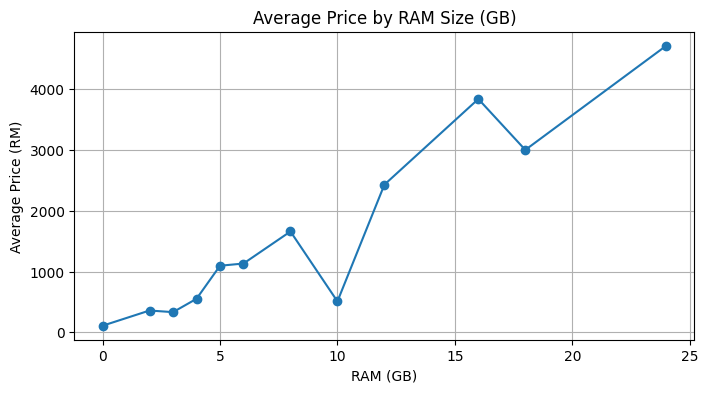

In [119]:
# Group by RAM
ram_avg = df.groupby('ram')['price'].mean().sort_index()

plt.figure(figsize=(8, 4))
ram_avg.plot(marker='o')
plt.title('Average Price by RAM Size (GB)')
plt.xlabel('RAM (GB)')
plt.ylabel('Average Price (RM)')
plt.grid(True)
plt.show()

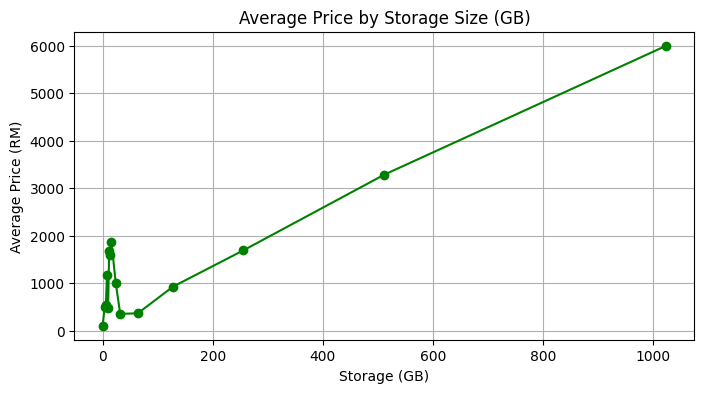

In [120]:
# Group by Storage
storage_avg = df.groupby('storage')['price'].mean().sort_index()

plt.figure(figsize=(8, 4))
storage_avg.plot(marker='o', color='green')
plt.title('Average Price by Storage Size (GB)')
plt.xlabel('Storage (GB)')
plt.ylabel('Average Price (RM)')
plt.grid(True)
plt.show()

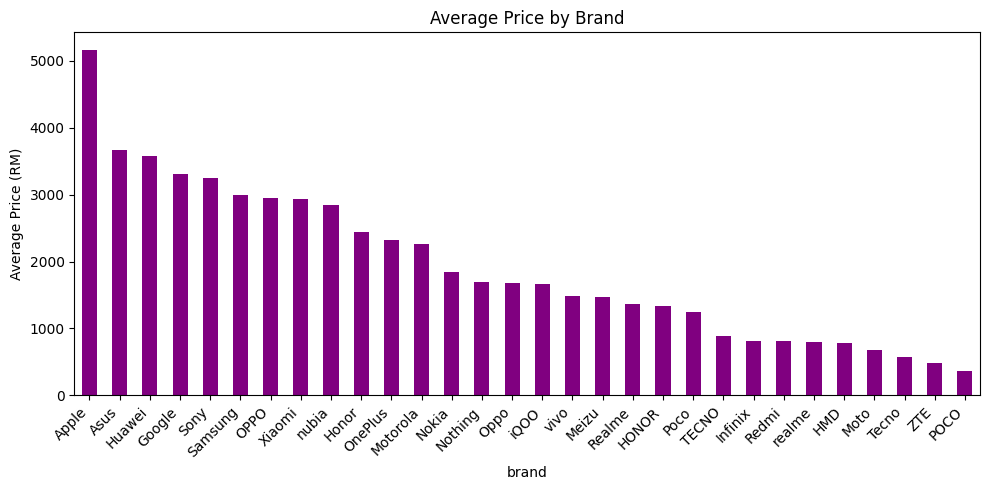

In [121]:
brand_avg = df.groupby('brand')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
brand_avg.plot(kind='bar', color='purple')
plt.title('Average Price by Brand')
plt.ylabel('Average Price (RM)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()